# Specification

## Project 1 -Predict secondary protein structure given the sequence. 

### Completion requirements:

- Reimplement the network described by Qian and Sejnowski in 1988


- Test and compare your accuracy - using their data


- Implement a single improvement, such as profiling


- Test and compare your accuracy again


- Does the model get similar accuracy on unseen datasets?


- Extend your work to other methods, e.g. can large language models help? How about SVMs?

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Import Dataset

In [199]:
# convert a sequence of amino acids to a one-hot encoded matrix
def one_hot_encode(seq, vocab):
    # Create a matrix of zeros, with dimensions len(seq) x len(vocab)
    one_hot = np.zeros((len(seq), len(vocab)), dtype=np.float32)
    # Iterate over the sequence and set the appropriate elements to 1.0
    for i, char in enumerate(seq):
        if char in vocab:
            one_hot[i, vocab.index(char)] = 1.0
    return one_hot


# prepare data to enter neural network
def prepare_data(filepath, window_size=13):
    sequences = []
    structures = []
    current_seq = []
    current_struct = []
    processing_sequence = False  # Track when inside a sequence block

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>': # Sequence separator
                if processing_sequence: 
                    if current_seq and current_struct:
                        seq_encoded = one_hot_encode(current_seq, aa_vocab) # One-hot encode sequence
                        struct_encoded = one_hot_encode(current_struct, structure_vocab) # One-hot encode structure

                        # Apply sliding window of determined size
                        for i in range(len(seq_encoded) - window_size + 1):
                            window = seq_encoded[i:i + window_size]
                            label = struct_encoded[i + window_size // 2]
                            sequences.append(window)
                            structures.append(label)

                    current_seq = []
                    current_struct = []
                processing_sequence = not processing_sequence
                continue

            elif 'end' in line:  # end of sequence or file
                continue  
            
            # If inside a sequence block, process the sequence
            # handles errors in sequence end lines in the dataset
            if processing_sequence:
                parts = line.split()
                if len(parts) != 2:
                    continue  
                current_seq.append(parts[0])
                current_struct.append(parts[1])

    return np.array(sequences), np.array(structures)


# define the vocabulary for amino acids and secondary structures
aa_vocab = 'ACDEFGHIKLMNPQRSTVWY_'  # 20 amino acids + 1 for gap/unknown
structure_vocab = 'he_'  # h for helix, e for sheet, _ for coil

train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

window_size = 13
x_train, y_train = prepare_data(train_path, window_size)
x_test, y_test = prepare_data(test_path, window_size)

In [200]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8110, 13, 21) (8110, 3)
(1714, 13, 21) (1714, 3)


# Model Architecture 

In [201]:
# Set random seed for reproducibility
tf.keras.utils.set_random_seed(42)

# Define the model architecture
hidden_units = 65  # Number of neurons in the hidden layer
model = Sequential([
    Flatten(input_shape=(window_size, 21)),  # The input shape is the window size x 21
    Dense(hidden_units, activation='sigmoid'),  # Hidden layer with sigmoid activation
    Dense(3, activation='linear')    # Output layer with linear activation for 3 classes
])

# Compile the model
model.compile(optimizer='sgd',  # Stochastic gradient descent to simulate backpropagation
              loss='mean_squared_error',  # Mean Squared Error as the loss function
              metrics=['accuracy'])  # Track accuracy

# Define early stopping callback to stop training when the validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=150,  #  number of epochs large enough to allow for convergence 
    batch_size=32,  # batch size of 32 
    validation_data=(x_test, y_test),  # Use the test set as the validation set
    callbacks=[early_stopping] # Use the early stopping callback

)

# Evaluate the model
final_pred = model.predict(x_test)


Epoch 1/150


c:\Users\tomev\anaconda3\envs\bio-cwk\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4893 - loss: 0.2594 - val_accuracy: 0.5484 - val_loss: 0.2024
Epoch 2/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5328 - loss: 0.2063 - val_accuracy: 0.5496 - val_loss: 0.2009
Epoch 3/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.5333 - loss: 0.2044 - val_accuracy: 0.5502 - val_loss: 0.1995
Epoch 4/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5343 - loss: 0.2026 - val_accuracy: 0.5519 - val_loss: 0.1981
Epoch 5/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.5366 - loss: 0.2008 - val_accuracy: 0.5525 - val_loss: 0.1968
Epoch 6/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.5365 - loss: 0.1992 - val_accuracy: 0.5543 - val_loss: 0.1956
Epoch 7/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.5366 - loss: 0.1977 - val_accuracy: 0.5554 - val_loss: 0.1944
Epoch 8/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.5374 - loss: 0.1962 - val_accu

In [202]:
# performance metrics

# Convert probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(final_pred, axis=1)

# Calculate accuracy/ Q3 score
accuracy = accuracy_score(y_true_labels, predicted_labels)
print("Q3 Score:", round(accuracy * 100, 1), "%") # 3 sf percentage

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient for each class
mcc_scores = []
for i in range(3):  # 3 classes: Helix, Sheet, Coil
    # Create binary arrays for each class
    true_binary = (y_true_labels == i).astype(int)
    pred_binary = (predicted_labels == i).astype(int)

    # Calculate MCC and handle cases with constant predictions
    if np.unique(true_binary).size > 1 and np.unique(pred_binary).size > 1:
        mcc = matthews_corrcoef(true_binary, pred_binary)
    else:
        mcc = 0  # Not enough data to compute MCC or one class constant
    mcc_scores.append(mcc)
    print(f"MCC for class {['Helix', 'Sheet', 'Coil'][i]}: {mcc:.2f}")

Q3 Score: 63.5 %
Confusion Matrix:
 [[178  25 232]
 [ 72 108 146]
 [ 98  53 802]]
MCC for class Helix: 0.30
MCC for class Sheet: 0.35
MCC for class Coil: 0.37


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


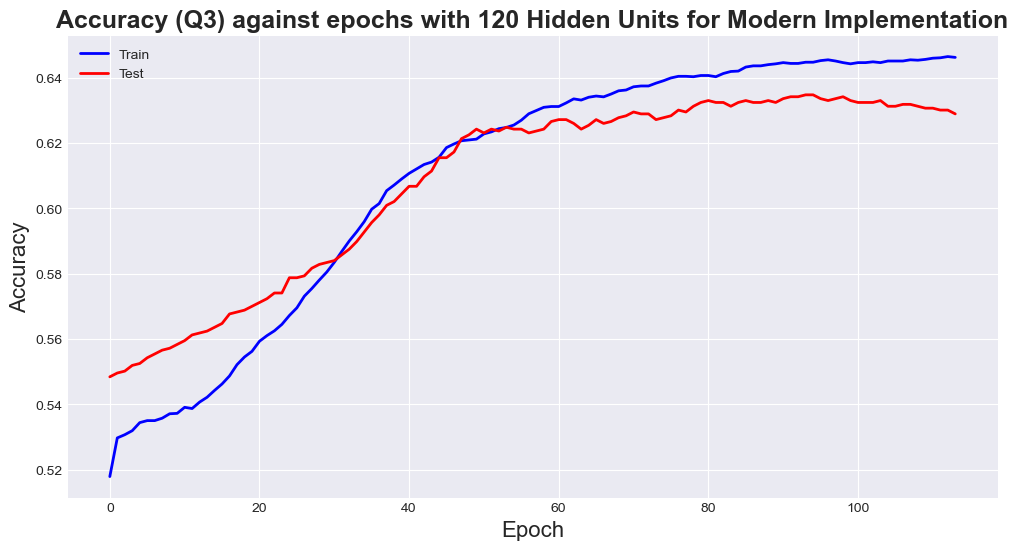

In [203]:
print(plt.style.available)

def plot_history(history):
 # Set the style
    plt.style.use('seaborn-v0_8-dark')  # Using a clean and professional style

    # Create figure and set size
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.plot(history.history['accuracy'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], linestyle='-', color='red', linewidth=2)
    plt.title('Accuracy (Q3) against epochs with 120 Hidden Units for Modern Implementation', fontsize=18, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)    
    
    # save the plot
    plt.savefig('figures/original_model_accuracy_120_units.png',dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

plot_history(history) 